Left "Cabin" out of the ensembles, mainly because I couldn't get a significant effect in a first run of random forests modeling (in R). There may be some value to it if we could figure out a way to convert cabin to distance from main deck.
 
Bootstrapped logistic regression and random forests had very similar results. They both tend to have higher omission error than comission error. That is, we tend to over-predict "death" in a way I can't resolve very well. But overall accuracy is ~0.7-0.8 for both, which I would call "good". I think Random Forests might be a little better at handling interactions, which I left out completely from my logistic regression. We might consider ensembling predictions from both models.

In [1]:
import sys
import pandas as pd
import numpy as np
from seaborn import histplot, pairplot

In [2]:
!git clone "https://github.com/ktaylora/EagleKahnXylem"

Cloning into 'EagleKahnXylem'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 24 (delta 8), reused 17 (delta 5), pack-reused 0
Unpacking objects: 100% (24/24), done.


In [78]:
training_data = pd.read_csv("EagleKahnXylem/Titanic/train.csv")
testing_data = pd.read_csv("EagleKahnXylem/Titanic/test.csv")

In [4]:
# lazily side-load our classification codebase from Github
sys.path.append("EagleKahnXylem")
from classification import *

Main Workflow

In [5]:
# if K is too high, we can't use it to estimate reliable std. error for our logistic regression, 
# but large K values makes for pretty predictive intervals for our models. Start low and 
# work high when we are ready to go to predict against our test data
K : int = 999 

In [79]:
# encode our ticket text to an integer -- larger numbers = greater complexity
training_data['Ticket'] = [ string_to_ordinal(x) for x in training_data['Ticket'] ]
training_data['Cabin'] = [ string_to_ordinal(x) for x in training_data['Cabin'] ]
training_data['Embarked'] = [ string_to_ordinal(x) for x in training_data['Embarked'] ]
training_data['Name'] = [ string_to_ordinal(x) for x in training_data['Name'] ]
# ditto for our testing dataset
testing_data['Ticket'] = [ string_to_ordinal(x) for x in testing_data['Ticket'] ]
testing_data['Cabin'] = [ string_to_ordinal(x) for x in testing_data['Cabin'] ]
testing_data['Embarked'] = [ string_to_ordinal(x) for x in testing_data['Embarked'] ]
testing_data['Name'] = [ string_to_ordinal(x) for x in testing_data['Name'] ]

In [80]:
# interpolate any remaining NA values
training_data.interpolate(inplace=True)
testing_data.interpolate(inplace=True)

Explore our training data -- some of this I did offline in 'R' with an overfit Random Forests model using all columns in our training dataframe

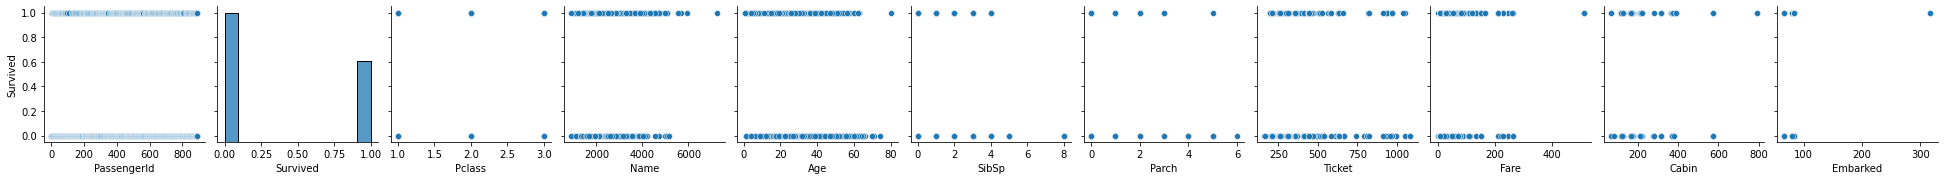

In [81]:
plot = pairplot(training_data, y_vars=['Survived'])

In [82]:
# use a 70/30 split for training/testing for bootstrapping
# and k-folds cross-validation
main_effects = ['Age', 'Fare','Ticket','Cabin','Parch','Pclass','SibSp','Embarked','Name']
k_folds = [ 
  shuffle(training_data, balance_classes=True, frac=0.85) 
  for i in range(K) ]
# bootstrap our logistic regression for estimating a confidence
# interval (standard error) and mean effect sizes from standardized
# coefficients
logistic_regressions = [ fit_logistic_regression(
    df['training'], variables = main_effects, 
    dummy_variables = ['Sex']) for df in k_folds ]

In [83]:
# grab the coefficients and standard error values from our bootstrapped 
# logistic regression classifiers
std_effect_sizes(logistic_regressions)

,est,se
Intercept,0.330152,0.001930
Age,-0.538769,0.002108
Fare,0.320265,0.003451
Ticket,-0.003350,0.001962
Cabin,-0.306242,0.002281
Parch,-0.134643,0.002560
Pclass,-0.613426,0.002673
SibSp,-0.402866,0.002693
Embarked,-0.071768,0.001159
Name,0.326945,0.002526


In [84]:
lreg_cv_results = pd.concat( cross_validation(
  logistic_regressions, k_folds=k_folds, variables=main_effects, 
  dummy_variables=["Sex"], apply_scale = True) )

(0.7841919589492373, 0.11282027427252464)


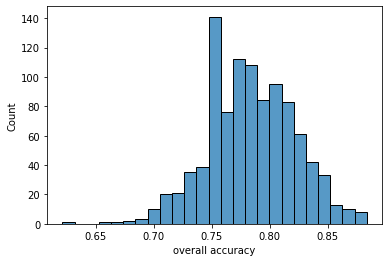

In [85]:
print( (lreg_cv_results['overall accuracy'].mean(), (3 * lreg_cv_results['overall accuracy'].std())) ) 
plot = histplot(lreg_cv_results['overall accuracy'])

(0.19363322803393282, 0.15778505264179601)


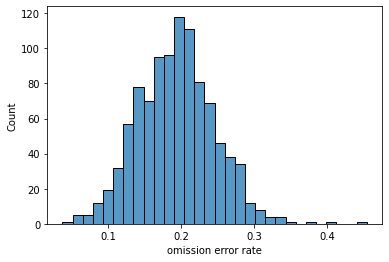

In [86]:
print( ( np.mean(lreg_cv_results['omission error rate']), (3 * np.std(lreg_cv_results['omission error rate'])) ) )
plot = histplot(lreg_cv_results['omission error rate'])

(0.23776478903113063, 0.1724251196795455)


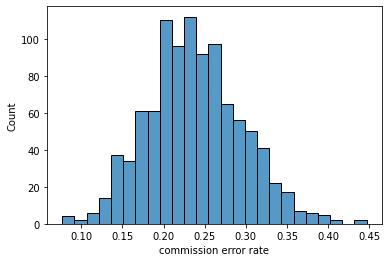

In [87]:
print( ( np.mean(lreg_cv_results['commission error rate']), (3 * np.std(lreg_cv_results['commission error rate'])) ) )
plot = histplot(lreg_cv_results['commission error rate'])

In [88]:
# Fit an exploratory RF classifier across K replicates to these variables -- they seems to be
# consistently important based on our regression modeling
random_forests = [ fit_random_forests(
  df['training'], variables = main_effects, dummy_variables=['Sex']) 
  for df in k_folds ]

In [89]:
rf_cv_results = pd.concat( cross_validation(
  random_forests, k_folds=k_folds, variables=main_effects, 
  dummy_variables=["Sex"], apply_scale = False) )

(0.8016851803259536, 0.11055367127907328)


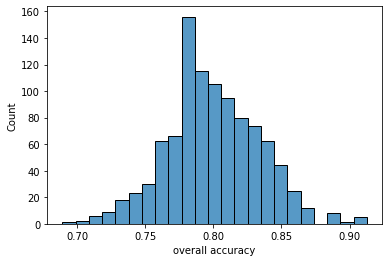

In [90]:
print( (rf_cv_results['overall accuracy'].mean(), (3 * rf_cv_results['overall accuracy'].std())) ) 
plot = histplot(rf_cv_results['overall accuracy'])

(0.17508384081506195, 0.15725892164759941)


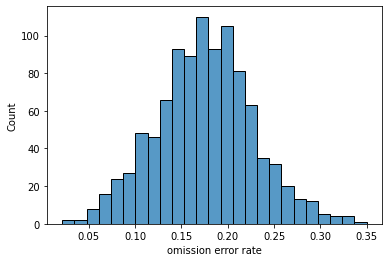

In [91]:
print( ( np.mean(rf_cv_results['omission error rate']), (3 * np.std(rf_cv_results['omission error rate'])) ) )
plot = histplot(rf_cv_results['omission error rate'])

(0.2211178966716682, 0.1734702332857348)


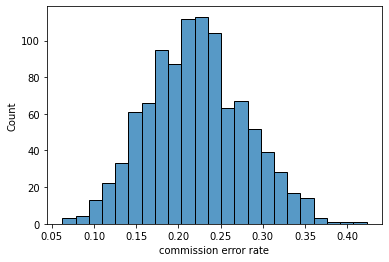

In [92]:
print( ( np.mean(rf_cv_results['commission error rate']), (3 * np.std(rf_cv_results['commission error rate'])) ) )
plot = histplot(rf_cv_results['commission error rate'])

Predict against Kaggle's testing datset and double-check our work by predicting against the full training dataset to make sure we are properly attributing predictions to passenger id, etc...

In [93]:
ensemble_testing_predictions = [ predict(
    m=m['model'],
    x=encode_design_matrix(testing_data, variables = main_effects, dummy_variables=['Sex'], normalize=False)['x']) for m in random_forests ]

In [94]:
ensemble_double_check_predictions = [ predict(
    m=m['model'],
    x=encode_design_matrix(training_data, variables = main_effects, dummy_variables=['Sex'], normalize=False)['x']) for m in random_forests ]

In [95]:
ensemble_testing_predictions = [ int(i) for i in np.median(ensemble_testing_predictions, axis=0) ]
ensemble_double_check_predictions = [ int(i) for i in np.median(ensemble_double_check_predictions, axis=0) ]

In [96]:
answer = pd.DataFrame(testing_data['PassengerId'])
answer['Survived'] = ensemble_testing_predictions

In [97]:
double_check = pd.DataFrame(training_data[['PassengerId','Survived']])
double_check['Prediction'] = ensemble_double_check_predictions

In [100]:
np.sum(double_check['Survived'] == double_check['Prediction'])

889

In [73]:
testing_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,305,7.8292,317,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,311,7.0000,317,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,309,9.6875,317,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,307,8.6625,317,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,360,12.2875,317,S


In [99]:
answer.to_csv('answer.csv', index=False)